# The intense drought on the Po river basin on summer 2022 

An interesting question one may want to 

<p align="center">
 <a href="https://www.greenandblue.it/2022/07/04/news/siccita_po_e_altri_fiumi_da_satellite-356491116/">
<img src="./img.png" alt="drought">
 </a>
</p>



Article from The Guardian: [Quiet flows the Po: the life and slow death of Italy's longest river](https://www.theguardian.com/environment/2022/jul/10/po-river-italy-drought-climate)

In [87]:
import climetlab as cml
import climetlab_cems_flood as cmf
import matplotlib.pyplot as plt
import datetime
import geopandas as gpd
import pandas as pd

We are going to check...

In [88]:
# pontelagoscuro
ps = {'name':'pontelagoscuro','lat':44.886111, 'lon':11.604444}

In [ ]:
seasonal = cml.load_dataset(
            'glofas-seasonal',
            model='lisflood',
            system_version='operational',
            temporal_filter= '2022 01-08 *',
            leadtime_hour = '24-3600',
            variable="river_discharge_in_the_last_24_hours",
            coords=[ps], 
            split_on=["month"],
            threads= 9
)

water_balance = cml.load_dataset(
            'glofas-historical',
            model='lisflood',
            product_type='intermediate',
            system_version='version_3_1',
            temporal_filter= '2022 01-07 *',
            variable="river_discharge_in_the_last_24_hours",
            coords=[ps],
            split_on = ['hmonth'],
            threads = 6
        )

climatology_2000_2021 = cml.load_dataset(
            'glofas-historical',
            model='lisflood',
            product_type='consolidated',
            system_version='version_3_1',
            temporal_filter= '2000-2021 01-10 *',
            variable="river_discharge_in_the_last_24_hours",
            coords=[ps],
            split_on = ['hyear','hmonth'],
            threads = 10
        )

By downloading data from this dataset, you agree to the terms and conditions defined at https://github.com/ecmwf-lab/climetlab_cems_flood/LICENSEIf you do not agree with such terms, do not download the data. 


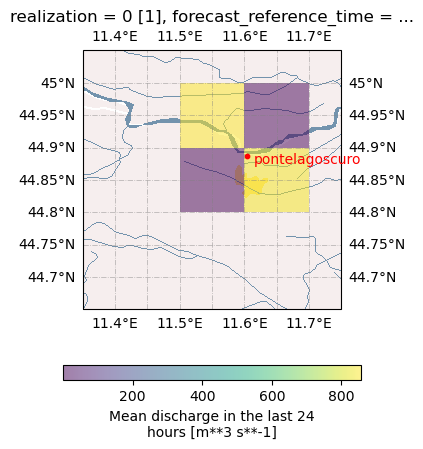

In [93]:
seasonal.show_coords('ponte')

In [118]:
seas = seasonal.to_xarray()

In [94]:
wb = water_balance.to_xarray()

In [95]:
cl = climatology_2000_2021.to_xarray()

In [107]:
cl = cl.chunk({"time":500})
cmean = cl.groupby("time.dayofyear").mean()
cmin = cl.groupby("time.dayofyear").min()
cmax = cl.groupby("time.dayofyear").max()

In [108]:
cmax = cmax.where(cmax.dayofyear != cmax.dayofyear[59], drop =True)

In [109]:
cmin = cmin.where(cmin.dayofyear != cmin.dayofyear[59], drop =True)

In [110]:
cmean = cmean.where(cmean.dayofyear != cmean.dayofyear[59], drop =True)

In [111]:
cmean

<xarray.Dataset>
Dimensions:    (dayofyear: 304, latitude: 2, longitude: 2)
Coordinates:
  * latitude   (latitude) float64 44.95 44.85
  * longitude  (longitude) float64 11.55 11.65
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 299 300 301 302 303 304 305
Data variables:
    dis24      (dayofyear, latitude, longitude) float32 dask.array<chunksize=(1, 2, 2), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-01-04T14:13 GRIB to CDM+CF via cfgrib-0.9.1...

In [114]:
cmean["time"] =  pd.date_range("2022-01-01","2022-10-31")
cmin["time"]=  pd.date_range("2022-01-01","2022-10-31")
cmax["time"] =  pd.date_range("2022-01-01","2022-10-31")

In [115]:
# plt.figure(figsize=(20,10))
# seas.dis24.isel(realization=0,leadtime=0,forecast_reference_time=0).plot()
# plt.scatter(ps[1],ps[0],s=10,color="red")

In [119]:
seas = seas.sel(lat=ps['lat'],lon=ps['lon'],method="nearest")

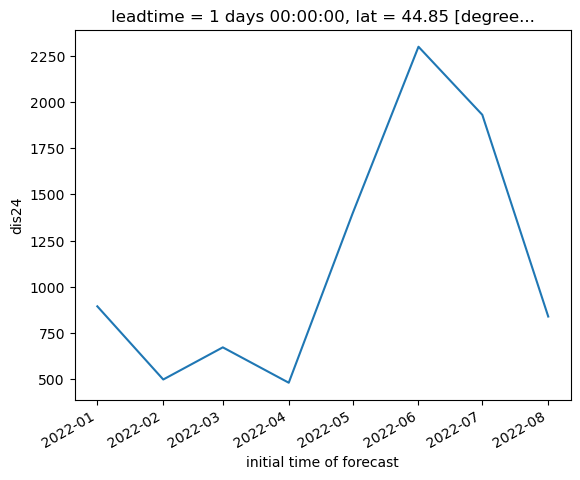

In [139]:
seas.isel(leadtime=0).mean("realization").dis24.plot()

In [120]:
cmean = cmean.sel(latitude=ps['lat'],longitude=ps['lon'],method="nearest")

cmax= cmax.sel(latitude=ps['lat'],longitude=ps['lon'],method="nearest")

cmin = cmin.sel(latitude=ps['lat'],longitude=ps['lon'],method="nearest")

In [127]:
wb = wb.sel(latitude=ps['lat'],longitude=ps['lon'],method="nearest")

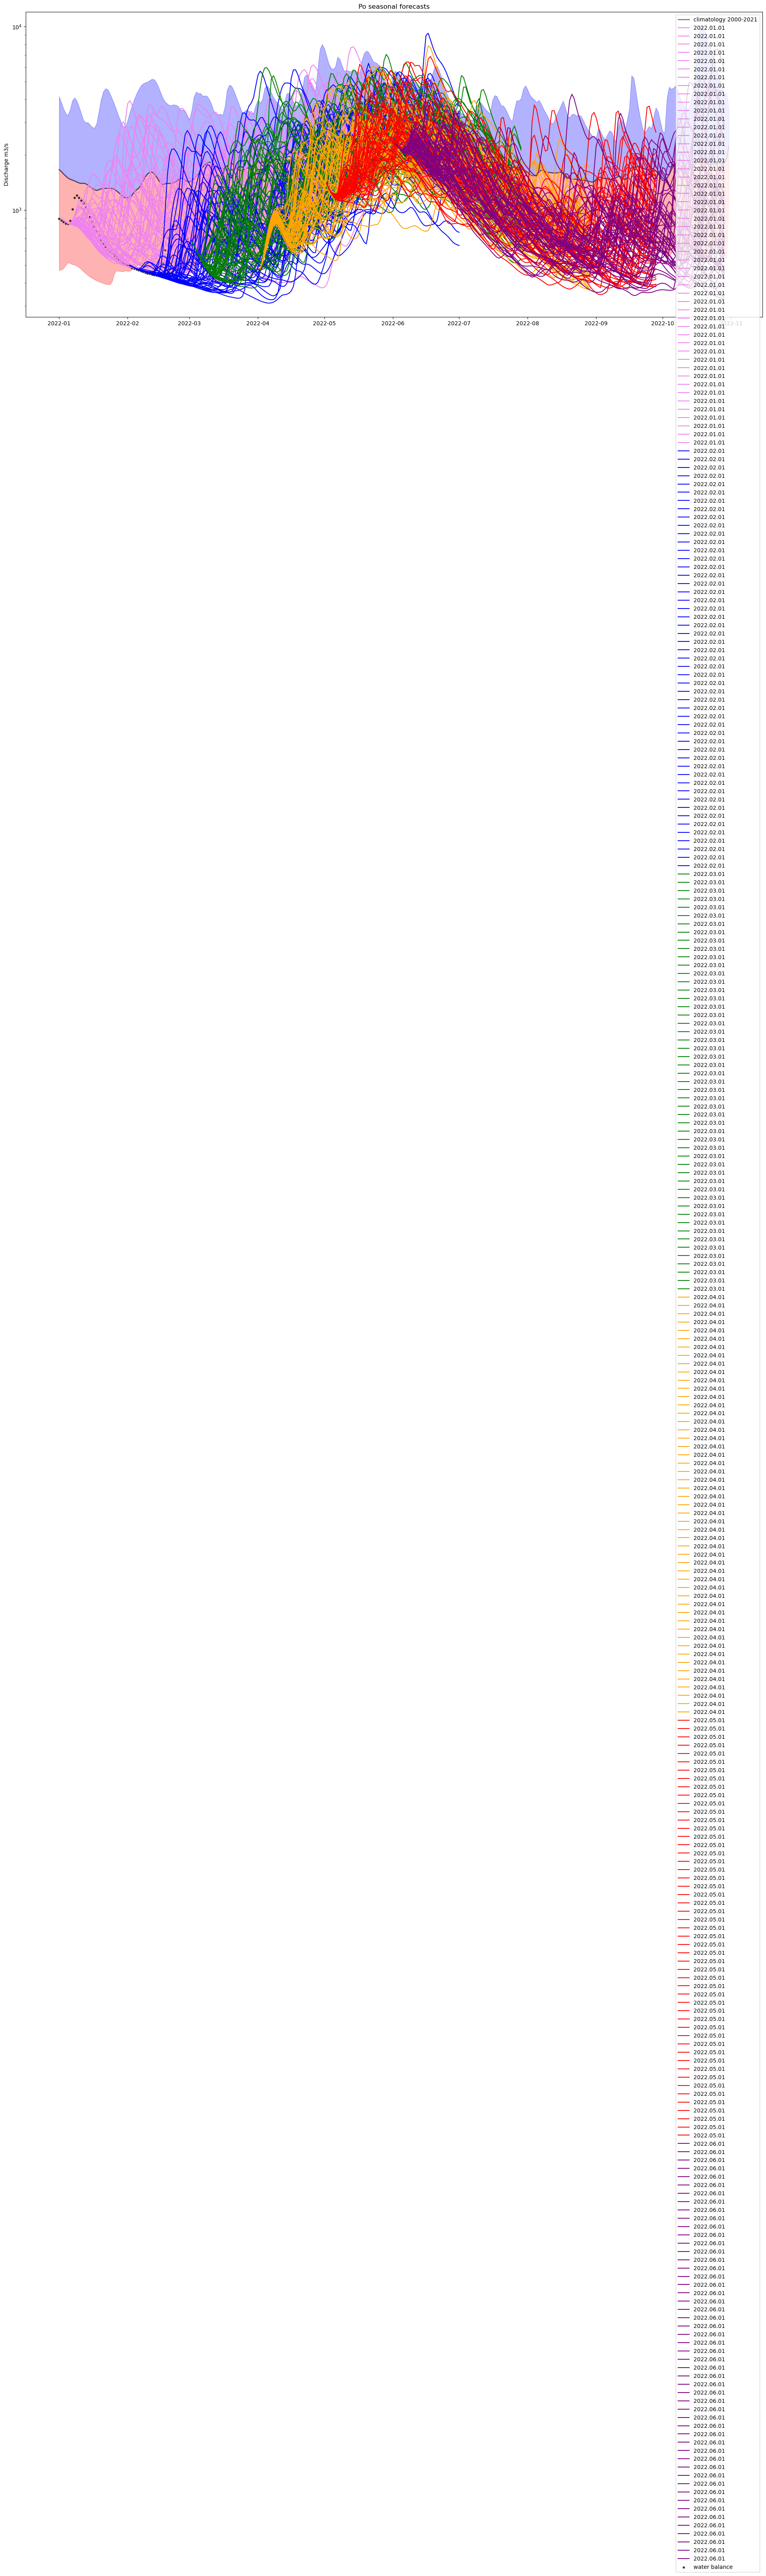

In [ ]:
plt.figure(figsize=(24,10))

plt.fill_between(cmin.time.values,cmean.dis24.values.T,cmax.dis24.values.T,color="blue",alpha=0.3)
plt.fill_between(cmin.time.values,cmin.dis24.values.T,cmean.dis24.values.T,color="red",alpha=0.3)
plt.plot(cmean.time.values,cmean.dis24.values.T, linewidth=2, color="black",label = "climatology 2000-2021", alpha=0.5)

for i,c in enumerate(["violet","blue","green","orange","red","purple"]):
    t = seas.dis24.forecast_reference_time[i].values
    t = pd.to_datetime(t).strftime('%Y.%m.%d')
    m = seas.dis24.isel(forecast_reference_time=i,drop=True)
    plt.plot(m.time.values, m.mean("realization").values.T,color=c, label=t)
plt.scatter(wb.time.values,wb.dis24.values.T,color="black",s=10, label="water balance", alpha=0.7)
#plt.vlines(x=datetime.datetime(2022,8,15),ymin=0,ymax=4300,linestyle="-.", color="black")
plt.legend()
plt.ylabel("Discharge m3/s") 
plt.title("Po seasonal forecasts")
plt.yscale("log")

In [133]:
m

<xarray.DataArray 'dis24' (realization: 51, leadtime: 150)>
array([[2298.0938 , 2244.4062 , 2162.125  , ...,  604.3125 ,  574.53125,
         548.2969 ],
       [2298.125  , 2244.375  , 2162.3125 , ..., 1133.8516 , 1075.1016 ,
        1018.9531 ],
       [2297.9688 , 2244.125  , 2160.1875 , ...,  577.02344,  606.1953 ,
         733.0156 ],
       ...,
       [2298.125  , 2244.3125 , 2161.5938 , ..., 7012.922  , 6400.5547 ,
        5808.1797 ],
       [2298.1875 , 2244.4688 , 2160.6875 , ...,  510.22656,  493.6172 ,
         478.96875],
       [2298.2188 , 2246.5625 , 2173.2188 , ..., 3182.9844 , 3095.5703 ,
        2843.25   ]], dtype=float32)
Coordinates:
  * realization  (realization) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49 50
  * leadtime     (leadtime) timedelta64[ns] 1 days 2 days ... 149 days 150 days
    lat          float64 44.85
    lon          float64 11.65
    time         (leadtime) datetime64[ns] 2022-06-02 2022-06-03 ... 2022-10-29
Attributes: (12/30)
    GRIB_paramId:                             240024
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      4
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avg
    ...                                       ...
    GRIB_shortName:                           dis24
    GRIB_totalNumber:                         0
    GRIB_units:                               m**3 s**-1
    long_name:                                Mean discharge in the last 24 h...
    units:                                    m**3 s**-1
    standard_name:                            unknown